# Todo
- Remove more features from 47 to get desired 35 
- Create 3 more models then use stacking method to predict houses in each group
- Validate each model. 
- Create the test data prediction function and transform the test data then predict using the best model

In [903]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
import pandas as pd
import numpy as np
import csv
import locale
from scipy.stats import randint
import joblib
locale.setlocale( locale.LC_ALL, '' )

'English_United States.1252'

In [904]:
def safe_log(x):
    return np.log(x + 1e-10)
#chat gpt

In [905]:
x = 0.0
result = np.log(x)  # This will result in a warning or an error
# Compare with safe_log
safe_result = safe_log(x)  # This will not result in errors
print(result, safe_result)

-inf -23.025850929940457


C:\Users\drew\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [906]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

In [907]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1022 non-null   int64  
 1   Id             1022 non-null   int64  
 2   MSSubClass     1022 non-null   int64  
 3   MSZoning       1022 non-null   object 
 4   LotFrontage    842 non-null    float64
 5   LotArea        1022 non-null   int64  
 6   Street         1022 non-null   object 
 7   Alley          60 non-null     object 
 8   LotShape       1022 non-null   object 
 9   LandContour    1022 non-null   object 
 10  Utilities      1022 non-null   object 
 11  LotConfig      1022 non-null   object 
 12  LandSlope      1022 non-null   object 
 13  Neighborhood   1022 non-null   object 
 14  Condition1     1022 non-null   object 
 15  Condition2     1022 non-null   object 
 16  BldgType       1022 non-null   object 
 17  HouseStyle     1022 non-null   object 
 18  OverallQ

In [908]:
housing = train_set.copy()

In [909]:
all_data_na = (housing.isnull().sum() / len(housing)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(15)

,Missing Ratio
PoolQC,99.510763
MiscFeature,96.868885
Alley,94.129159
Fence,80.626223
FireplaceQu,46.966732
LotFrontage,17.612524
GarageType,5.283757
GarageYrBlt,5.283757
GarageFinish,5.283757
GarageQual,5.283757


We fill the missing values by 0 if the type of the input is an integer, and we fill ‘None’ if it’s categorical.

In [910]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    housing[col] = housing[col].fillna(0)
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass' ):
    housing[col] = housing[col].fillna('None')

For the following input variables, we fill the missing values with the most frequent value. Notice that the variable LotFrontage is of type “float”. In general, the LotFrontage of a house is more or less equal to the Neighborhood houses. Hence we group the data by “Neighborhood” and fill the missing values with a median value of the neighborhood houses.

In [911]:
housing["LotFrontage"] = housing.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
housing['MSZoning'] = housing['MSZoning'].fillna(housing['MSZoning'].mode()[0])
housing['Electrical'] = housing['Electrical'].fillna(housing['Electrical'].mode()[0])
housing['KitchenQual'] = housing['KitchenQual'].fillna(housing['KitchenQual'].mode()[0])
housing['Exterior1st'] = housing['Exterior1st'].fillna(housing['Exterior1st'].mode()[0])
housing['Exterior2nd'] = housing['Exterior2nd'].fillna(housing['Exterior2nd'].mode()[0])
housing['SaleType'] = housing['SaleType'].fillna(housing['SaleType'].mode()[0])

In [912]:
#almost all of Utilities is the same
housing = housing.drop(['Utilities'], axis=1)
#replace missing values with "Typ"
housing["Functional"] = housing["Functional"].fillna("Typ")
#combine features
housing['TotalSF'] = housing['TotalBsmtSF'] + housing['1stFlrSF'] + housing['2ndFlrSF']
# dropped because overfitting
housing = housing.drop("Id", axis=1)
# considered irrelevant from histograms (too many 0 values)
housing = housing.drop("MSZoning", axis=1) 
housing = housing.drop("YrSold", axis=1) 
housing = housing.drop("LowQualFinSF", axis=1)

housing = housing.drop("PoolQC", axis=1)
housing = housing.drop("Fence", axis=1)
housing = housing.drop("MiscFeature", axis=1)
housing = housing.drop("FireplaceQu", axis=1)
housing = housing.drop("Alley", axis=1)
# changes to data

corr_matrix = housing.corr()
list_col = list(corr_matrix)
corr_matrix["SalePrice"]


Unnamed: 0      -0.035452
MSSubClass      -0.076696
LotFrontage      0.344844
LotArea          0.257302
OverallQual      0.789634
OverallCond     -0.083465
YearBuilt        0.542773
YearRemodAdd     0.510283
MasVnrArea       0.469071
BsmtFinSF1       0.398335
BsmtFinSF2      -0.004278
BsmtUnfSF        0.218188
TotalBsmtSF      0.612676
1stFlrSF         0.611725
2ndFlrSF         0.308750
GrLivArea        0.719985
BsmtFullBath     0.226761
BsmtHalfBath    -0.015511
FullBath         0.570163
HalfBath         0.284235
BedroomAbvGr     0.175139
KitchenAbvGr    -0.132590
TotRmsAbvGrd     0.555989
Fireplaces       0.475610
GarageYrBlt      0.260569
GarageCars       0.634395
GarageArea       0.626319
WoodDeckSF       0.308526
OpenPorchSF      0.317960
EnclosedPorch   -0.128401
3SsnPorch        0.032842
ScreenPorch      0.103018
PoolArea         0.116425
MiscVal         -0.029293
MoSold           0.060779
SalePrice        1.000000
TotalSF          0.785196
Name: SalePrice, dtype: float64

In [913]:
#no more missing values
all_data_na = (housing.isnull().sum() / len(housing)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


# collinearity

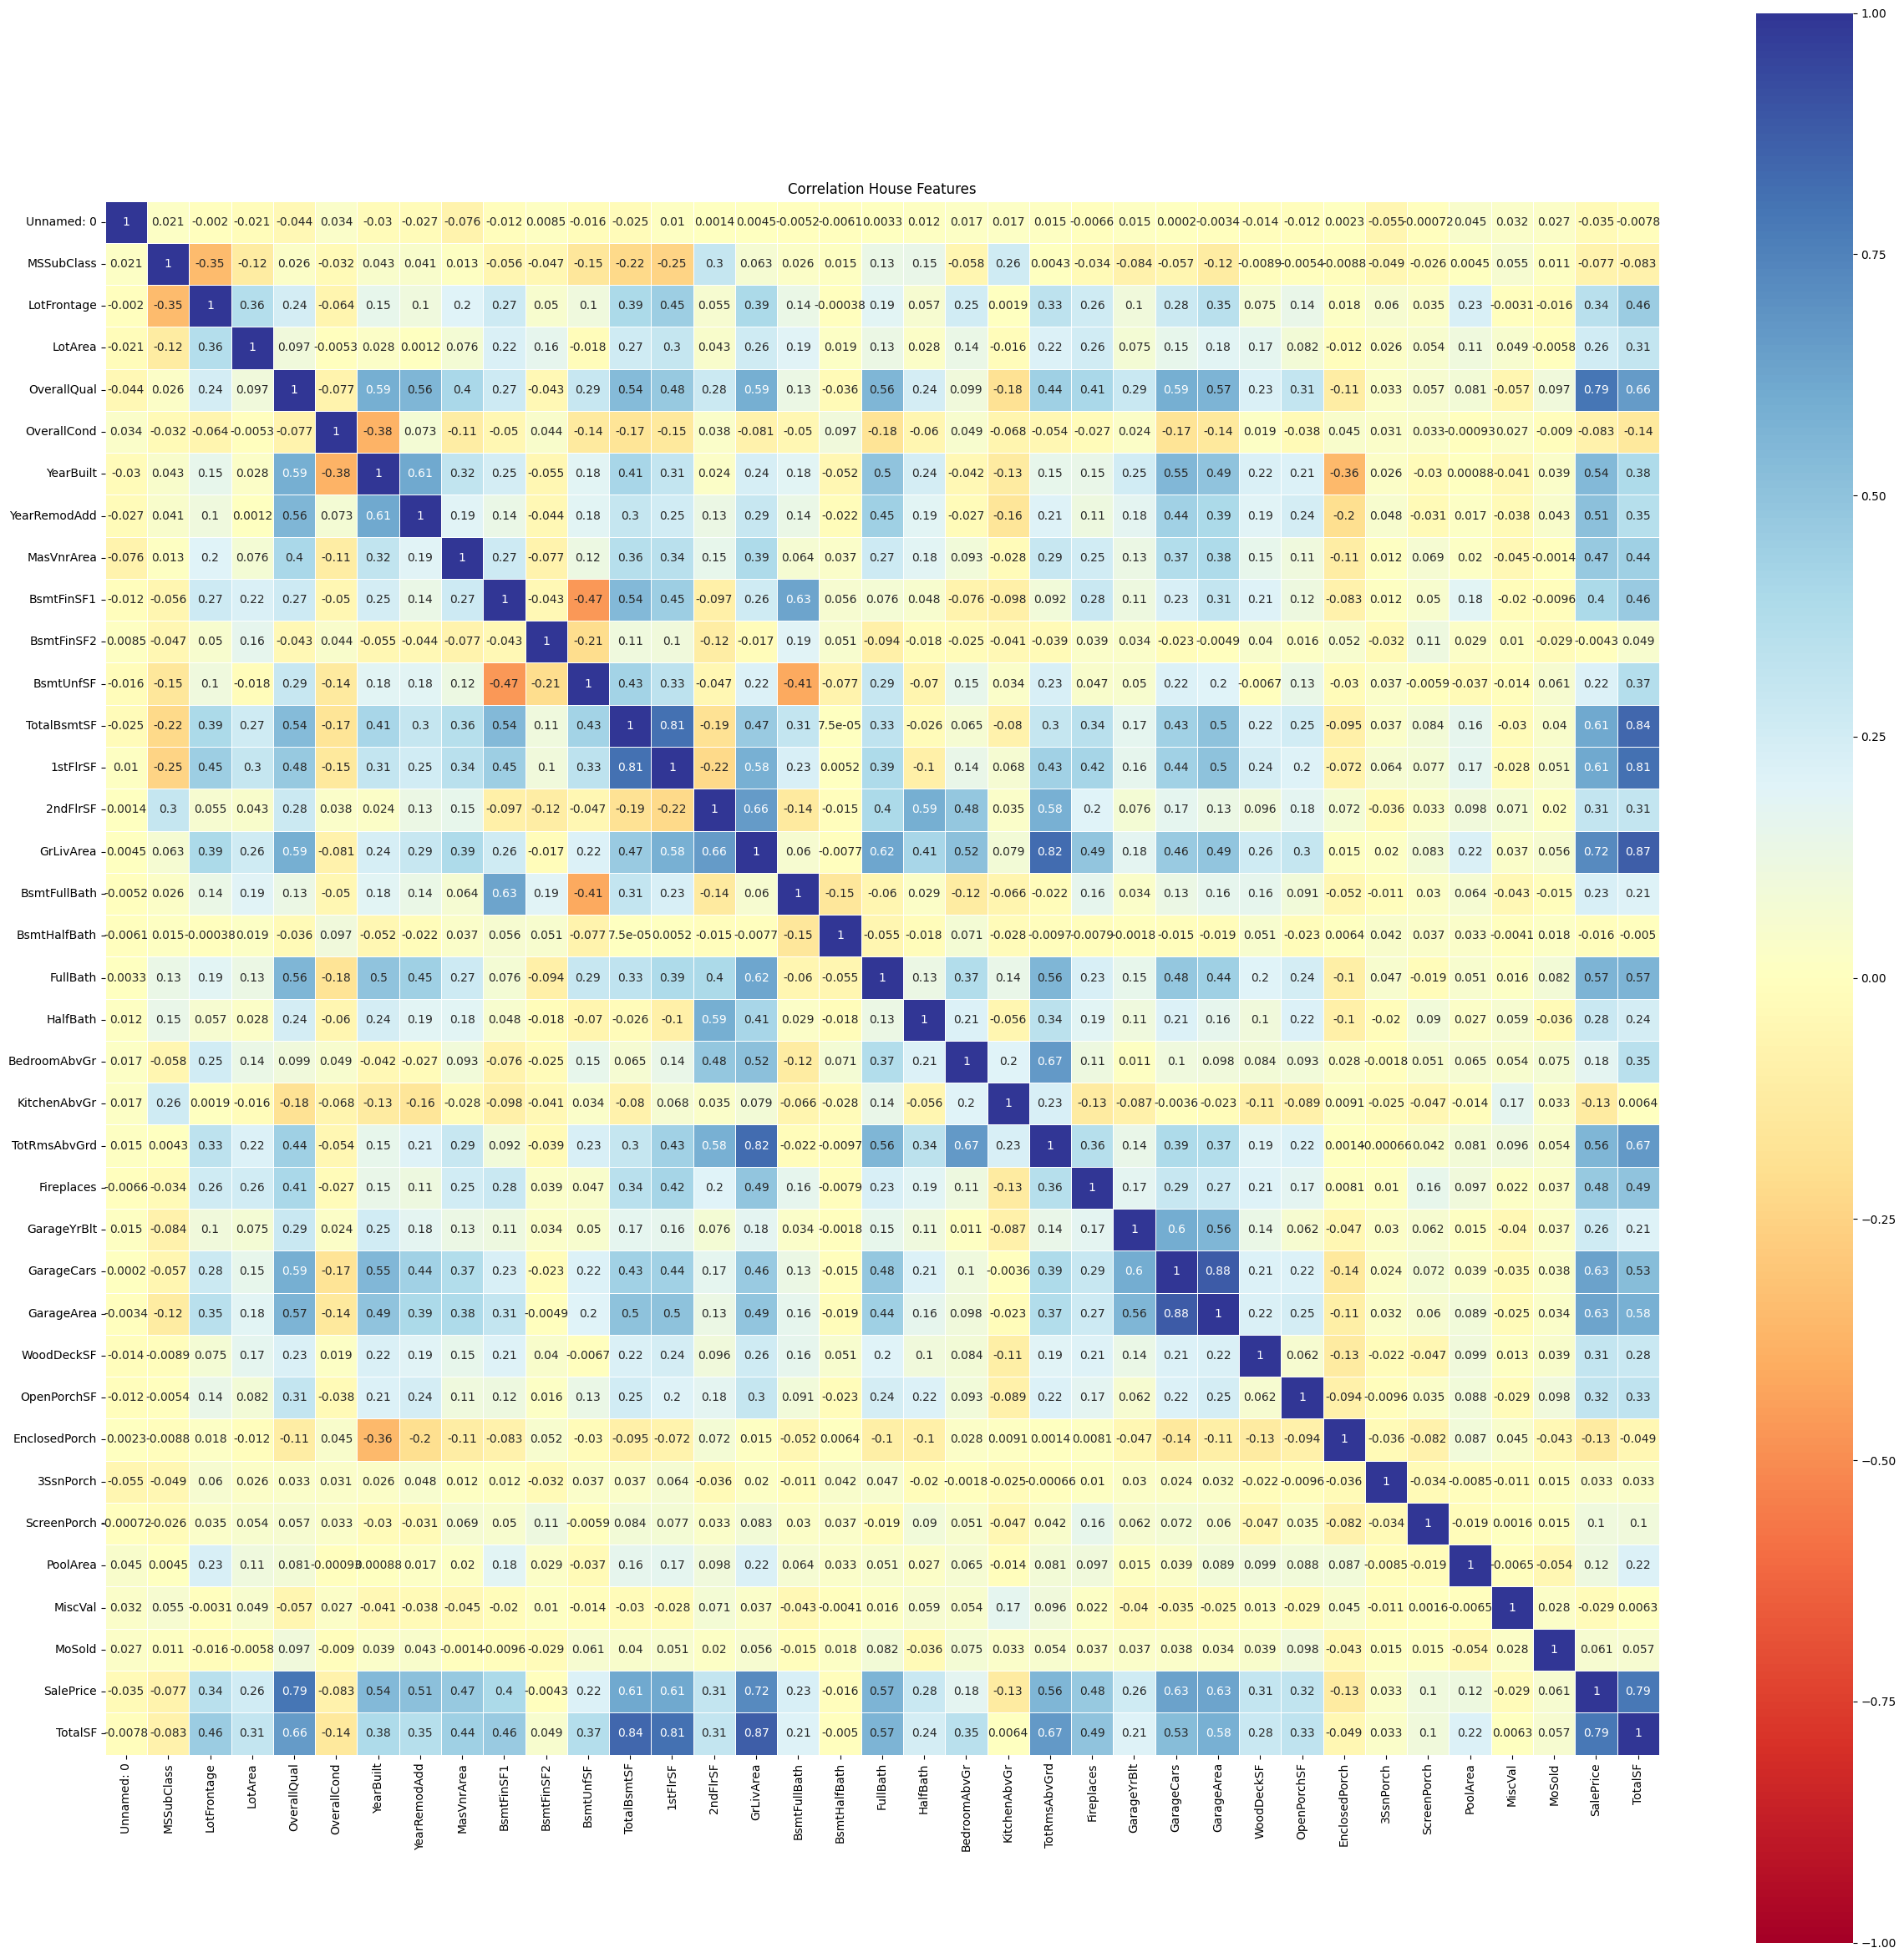

In [914]:
#Get dataframe of only numberic columns
import matplotlib.pyplot as plt 
import seaborn as sns
dfnumeric = housing._get_numeric_data()
corrmat = dfnumeric.corr()

f, ax = plt.subplots(figsize = (30,30))
sns.heatmap(corrmat, vmin = -1, vmax = 1, square=True, annot = True, cmap = 'RdYlBu', linewidths =.5)
plt.title('Correlation House Features')

plt.show();

# Outliers

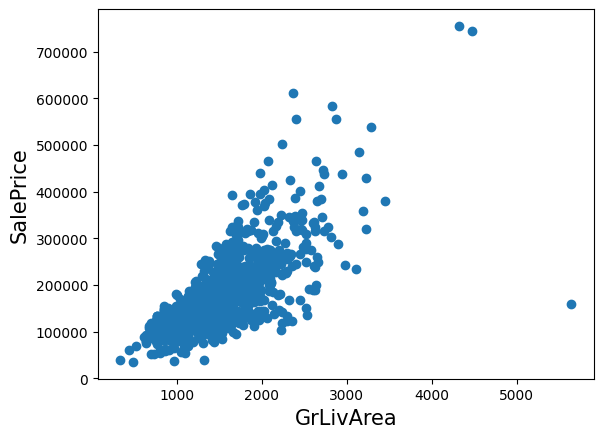

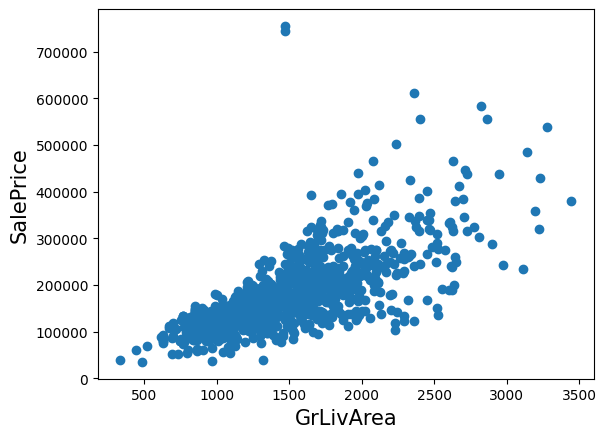

In [915]:

fig, ax = plt.subplots()
ax.scatter(x = housing['GrLivArea'], y = housing['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()


# Replace outliers with the mean of "GrLivArea" excluding outliers
mean_grlivarea = np.median(housing.loc[housing['GrLivArea'] <= 4000, 'GrLivArea'])
housing.loc[housing['GrLivArea'] > 4000, 'GrLivArea'] = mean_grlivarea
        
fig, ax = plt.subplots()
ax.scatter(x = housing['GrLivArea'], y = housing['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

# Cleaning Data

dropping all values with lower than 0.5 correlation leaves us with 47 values

In [916]:
housing_labels = pd.DataFrame(train_set["SalePrice"].copy())
housing = housing.drop("SalePrice", axis=1)
ids = test_set["Id"]
#drop cols with <0.5 correlation
for k in range(len(list_col)):
    if corr_matrix["SalePrice"][k] < 0.5:
        housing = housing.drop(f"{list_col[k]}", axis=1)
len(list(housing.columns))

47

In [917]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Street         1022 non-null   object
 1   LotShape       1022 non-null   object
 2   LandContour    1022 non-null   object
 3   LotConfig      1022 non-null   object
 4   LandSlope      1022 non-null   object
 5   Neighborhood   1022 non-null   object
 6   Condition1     1022 non-null   object
 7   Condition2     1022 non-null   object
 8   BldgType       1022 non-null   object
 9   HouseStyle     1022 non-null   object
 10  OverallQual    1022 non-null   int64 
 11  YearBuilt      1022 non-null   int64 
 12  YearRemodAdd   1022 non-null   int64 
 13  RoofStyle      1022 non-null   object
 14  RoofMatl       1022 non-null   object
 15  Exterior1st    1022 non-null   object
 16  Exterior2nd    1022 non-null   object
 17  MasVnrType     1022 non-null   object
 18  ExterQual      1022 non-null

Use one hot encoder for categorical features then use standard scaler for numerical features to make them between 0-1 as well. 

In [918]:
text_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
num_norm_pipeline = make_pipeline(StandardScaler())
preprocess = ColumnTransformer([
    ("text", text_pipeline, make_column_selector(dtype_include=object))],
    remainder=num_norm_pipeline
)

# Classifier K means

In [919]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
# Classifier pipeline (k-means)
k_means_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('kmeans', KMeans())
])
# Parameters for grid search
param_grid = {
    'kmeans__n_clusters': [2, 3, 4, 5],  #range of clusters
}
#Grid search with k-fold cross-validation
grid_search = GridSearchCV(k_means_pipeline, param_grid, cv=5)  # Adjust cv as needed
#Fit the pipeline with grid search on your data
grid_search.fit(housing, housing_labels)
#Access the best parameters and the fitted model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(best_params)

{'kmeans__n_clusters': 5}


In [920]:
# KMeans pipeline
k_means_pipeline = make_pipeline(preprocess, KMeans(n_clusters=5))  

# Fit KMeans and get cluster assignments
cluster_assignments = k_means_pipeline.fit_predict(housing)

# Add cluster assignments to the original DataFrame
housing_clustered = pd.concat([housing, pd.Series(cluster_assignments, name='Cluster')], axis=1)

# Print the DataFrame with cluster assignments
print(housing_clustered['Cluster'])

0       1
1       0
2       4
3       1
4       0
       ..
1017    4
1018    4
1019    0
1020    4
1021    0
Name: Cluster, Length: 1022, dtype: int32


In [921]:
# Linear regression pipeline
lin_reg_pipeline = make_pipeline(preprocess, LinearRegression())
# Loop through each cluster
for i in range(5):  # Assuming 5 clusters
    # Filter data for the current cluster
    cluster_data = housing_clustered[housing_clustered['Cluster'] == i]
    X_cluster = cluster_data.drop(columns=['Cluster'])  # Features for the current cluster
    y_cluster = housing_labels.loc[cluster_data.index]  # Replace 'your_target_column' with your actual target column

    # Fit the linear regression model for the current cluster
    lin_reg_pipeline.fit(X_cluster, y_cluster)

    # Make predictions for the entire dataset
    housing_predictions = lin_reg_pipeline.predict(housing)

    # Print some predictions for the current cluster
    for idx in cluster_data.index[:10]:  # Print for the first 10 rows in the cluster
        print(f"Cluster {i}, Real value: {locale.currency(y_cluster.loc[idx].values[0], grouping=True)}, Prediction: {locale.currency(housing_predictions[cluster_data.index.get_loc(idx)].round(2), grouping=True)}")


Cluster 0, Real value: $108,000.00, Prediction: $217,663.00
Cluster 0, Real value: $129,900.00, Prediction: $109,728.83
Cluster 0, Real value: $153,900.00, Prediction: $165,026.78
Cluster 0, Real value: $153,575.00, Prediction: $174,723.55
Cluster 0, Real value: $144,000.00, Prediction: $115,229.87
Cluster 0, Real value: $131,000.00, Prediction: $192,632.11
Cluster 0, Real value: $113,000.00, Prediction: $155,935.42
Cluster 0, Real value: $64,500.00, Prediction: $169,139.39
Cluster 0, Real value: $128,500.00, Prediction: $202,443.75
Cluster 0, Real value: $133,900.00, Prediction: $118,976.21
Cluster 1, Real value: $219,500.00, Prediction: $235,104.00
Cluster 1, Real value: $197,000.00, Prediction: ($8,314,738,605,815,840.00)
Cluster 1, Real value: $187,500.00, Prediction: $1,518,725,170,211,552.00
Cluster 1, Real value: $193,879.00, Prediction: $205,856.00
Cluster 1, Real value: $263,435.00, Prediction: $76,416.00
Cluster 1, Real value: $149,000.00, Prediction: $189,632.00
Cluster 1, R

In [922]:
lin_reg = Pipeline([("pre", preprocess),  ("reg", LinearRegression())])
lin_reg.fit(housing, housing_labels)

housing_predictions = lin_reg.predict(housing)
for k in range(10):
    print(f"Real value: {locale.currency(housing_labels.iloc[k].values[0], grouping=True)}, Prediction: {locale.currency(housing_predictions[k][0].round(2), grouping=True)}")

Real value: $219,500.00, Prediction: $224,629.59
Real value: $108,000.00, Prediction: $105,123.88
Real value: $176,000.00, Prediction: $194,438.54
Real value: $197,000.00, Prediction: $186,989.63
Real value: $129,900.00, Prediction: $101,568.36
Real value: $187,500.00, Prediction: $205,123.90
Real value: $167,000.00, Prediction: $181,697.17
Real value: $165,000.00, Prediction: $174,847.33
Real value: $193,879.00, Prediction: $196,934.89
Real value: $157,500.00, Prediction: $155,393.58


In [923]:
lin_rmse = mean_squared_error(safe_log(housing_labels), safe_log(housing_predictions), squared=False)
print(lin_rmse)

0.12230927968879901


In [924]:
housing_predictions2 = lin_reg.predict(housing)
lin_rmse2 = mean_squared_error(housing_labels, housing_predictions2, squared=False)
print(lin_rmse2)

20632.81477436278


In [925]:
for k in range(10):
    print(f"Real value: {locale.currency(housing_labels.iloc[k].values[0], grouping=True)}, Prediction: {locale.currency(housing_predictions2[k][0].round(2), grouping=True)}")

Real value: $219,500.00, Prediction: $224,629.59
Real value: $108,000.00, Prediction: $105,123.88
Real value: $176,000.00, Prediction: $194,438.54
Real value: $197,000.00, Prediction: $186,989.63
Real value: $129,900.00, Prediction: $101,568.36
Real value: $187,500.00, Prediction: $205,123.90
Real value: $167,000.00, Prediction: $181,697.17
Real value: $165,000.00, Prediction: $174,847.33
Real value: $193,879.00, Prediction: $196,934.89
Real value: $157,500.00, Prediction: $155,393.58
